In [1]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.measure import regionprops
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import argparse
from PIL import Image
import cv2
import copy
from skimage import io, color

In [2]:
name_image_1 = "test2.jpg"
name_image_2 = "test3.jpg"

In [3]:
def segment_slic(image_name):
    image = img_as_float(io.imread(image_name))
    numSegments = 200
    segments = slic(image, n_segments = numSegments, sigma = 0)
    fig = plt.figure("Superpixels",figsize=(60,60))
    ax = fig.add_subplot(5,5,5)
    ax.imshow(mark_boundaries(image, segments))
    plt.show()
    
    print("number segment ",np.max(segments))
    
    return segments

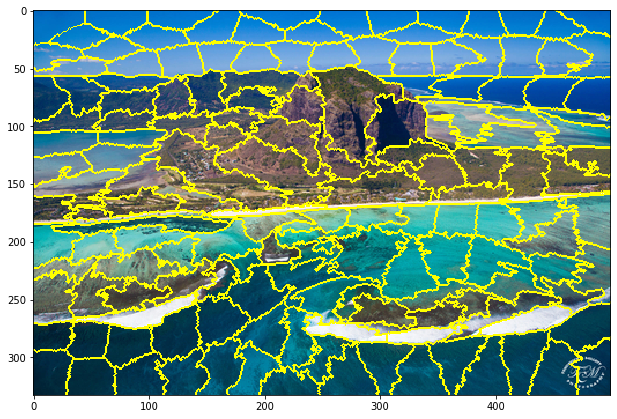

number segment  148


In [4]:
segments1 = segment_slic(name_image_1)

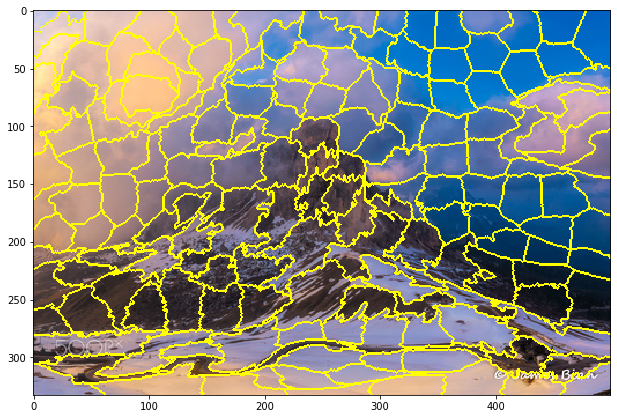

number segment  166


In [5]:
segments2 = segment_slic(name_image_2)

In [6]:
def read_image_rgb(image_name):
    image_rgb = io.imread(image_name)
    return image_rgb

image1_rgb = read_image_rgb(name_image_1)
image2_rgb = read_image_rgb(name_image_2)

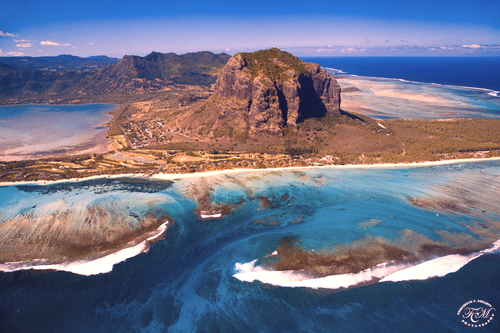

In [7]:
# linear Monge-Kantorovitch
def colour_transfer_MKL(I0, I1):
    I0 = I0 / 255
    I1 = I1 / 255
    assert len(I0.shape) == 3
    X0 = I0.reshape(-1, I0.shape[2])
    X1 = I1.reshape(-1, I1.shape[2])
    A = np.cov(X0.T)
    B = np.cov(X1.T)
    T = MKL(A, B)
    XR = (X0-X0.mean(0)).dot(T) + X1.mean(0)
    XR = XR.reshape(I0.shape)
    XR = np.clip(XR, 0, 1.0)
    XR = (XR*255).astype(np.uint8)
    return XR

def MKL(A, B):
    eps = 2.2204e-16
    N = A.shape[0]

    Da2, Ua = np.linalg.eig(A);
    Da2[Da2<0] = 0
    Da2 = Da2[::-1]
    Ua = Ua[:, ::-1]

    Da = np.diag(np.sqrt(Da2 + eps));
    C = Da.dot(Ua.T).dot(B).dot(Ua).dot(Da);

    Dc2, Uc = np.linalg.eig(C);
    Dc2[Dc2<0] = 0;
    Dc = np.diag(np.sqrt(Dc2 + eps));
    Da_inv = np.diag(1./(np.diag(Da)))

    return Ua.dot(Da_inv).dot(Uc).dot(Dc).dot(Uc.T).dot(Da_inv).dot(Ua.T);


IR_mkl = colour_transfer_MKL(image1_rgb,image2_rgb)
img = Image.fromarray(IR_mkl, 'RGB')
img

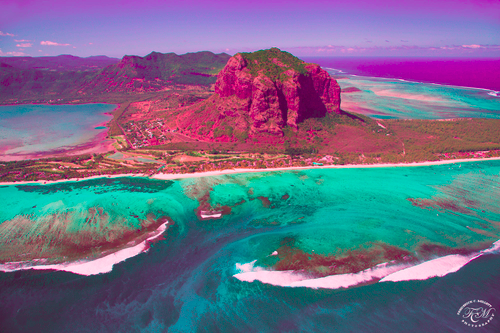

In [8]:
def color_transfer(source, target, clip=True, preserve_paper=True):
    source = cv2.cvtColor(source, cv2.COLOR_RGB2LAB).astype("float32")
    target = cv2.cvtColor(target, cv2.COLOR_RGB2LAB).astype("float32")

    # compute color statistics for the source and target images
    (lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(source)
    (lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(target)

    # subtract the means from the target image
    (l, a, b) = cv2.split(target)
    l -= lMeanTar
    a -= aMeanTar
    b -= bMeanTar

    if preserve_paper:
        # scale by the standard deviations using paper proposed factor
        l = (lStdTar / lStdSrc) * l
        a = (aStdTar / aStdSrc) * a
        b = (bStdTar / bStdSrc) * b
    else:
        # scale by the standard deviations using reciprocal of paper proposed factor
        l = (lStdSrc / lStdTar) * l
        a = (aStdSrc / aStdTar) * a
        b = (bStdSrc / bStdTar) * b

    # add in the source mean
    l += lMeanSrc
    a += aMeanSrc
    b += bMeanSrc

    # clip/scale the pixel intensities to [0, 255] if they fall
    # outside this range
    l = _scale_array(l, clip=clip)
    a = _scale_array(a, clip=clip)
    b = _scale_array(b, clip=clip)

    # merge the channels together and convert back to the RGB color
    # space, being sure to utilize the 8-bit unsigned integer data
    # type
    transfer = cv2.merge([l, a, b])
    transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2RGB)

    # return the color transferred image
    return transfer


def image_stats(image):
    (l, a, b) = cv2.split(image)
    (lMean, lStd) = (l.mean(), l.std())
    (aMean, aStd) = (a.mean(), a.std())
    (bMean, bStd) = (b.mean(), b.std())

    # return the color statistics
    return (lMean, lStd, aMean, aStd, bMean, bStd)


def _min_max_scale(arr, new_range=(0, 255)):
    mn = arr.min()
    mx = arr.max()

    # check if scaling needs to be done to be in new_range
    if mn < new_range[0] or mx > new_range[1]:
        # perform min-max scaling
        scaled = (new_range[1] - new_range[0]) * \
            (arr - mn) / (mx - mn) + new_range[0]
    else:
        # return array if already in range
        scaled = arr

    return scaled


def _scale_array(arr, clip=True):
    if clip:
        scaled = np.clip(arr, 0, 255)
    else:
        scale_range = (max([arr.min(), 0]), min([arr.max(), 255]))
        scaled = _min_max_scale(arr, new_range=scale_range)

    return scaled


source = image2_rgb
target = image1_rgb

source_flat = source.reshape(1,source.shape[0]*source.shape[1],3)
target_flat = target.reshape(1,target.shape[0]*target.shape[1],3)

transfer = color_transfer(source_flat, target_flat, clip="t", preserve_paper='t')
transfer = transfer.reshape(source.shape[0],source.shape[1],3)

img = Image.fromarray(transfer, 'RGB')
img

In [9]:
def find_mean_each_segment(segments,image_rgb):
    mean_color_arr = []
    for seg_num in range(np.max(segments)+1):
        print("doing seg",seg_num)
        mean_seg_arr = []
        for (index1, item1) in enumerate(segments):
            for (index2, item2) in enumerate(item1):
                if(segments[index1][index2] == seg_num):
                    mean_seg_arr.append(image_rgb[index1][index2])

        mean_seg_arr = np.asarray(mean_seg_arr)
        mean_seg = np.mean(mean_seg_arr,axis=0)
        mean_color_arr.append(mean_seg)
        
    mean_color_arr = np.asarray(mean_color_arr)
    return mean_color_arr

arr_mean_seg_1 = find_mean_each_segment(segments1,image1_rgb)
arr_mean_seg_2 = find_mean_each_segment(segments2,image2_rgb)

doing seg 0
doing seg 1
doing seg 2
doing seg 3
doing seg 4
doing seg 5
doing seg 6
doing seg 7
doing seg 8
doing seg 9
doing seg 10
doing seg 11
doing seg 12
doing seg 13
doing seg 14
doing seg 15
doing seg 16
doing seg 17
doing seg 18
doing seg 19
doing seg 20
doing seg 21
doing seg 22
doing seg 23
doing seg 24
doing seg 25
doing seg 26
doing seg 27
doing seg 28
doing seg 29
doing seg 30
doing seg 31
doing seg 32
doing seg 33
doing seg 34
doing seg 35
doing seg 36
doing seg 37
doing seg 38
doing seg 39
doing seg 40
doing seg 41
doing seg 42
doing seg 43
doing seg 44
doing seg 45
doing seg 46
doing seg 47
doing seg 48
doing seg 49
doing seg 50
doing seg 51
doing seg 52
doing seg 53
doing seg 54
doing seg 55
doing seg 56
doing seg 57
doing seg 58
doing seg 59
doing seg 60
doing seg 61
doing seg 62
doing seg 63
doing seg 64
doing seg 65
doing seg 66
doing seg 67
doing seg 68
doing seg 69
doing seg 70
doing seg 71
doing seg 72
doing seg 73
doing seg 74
doing seg 75
doing seg 76
doing seg

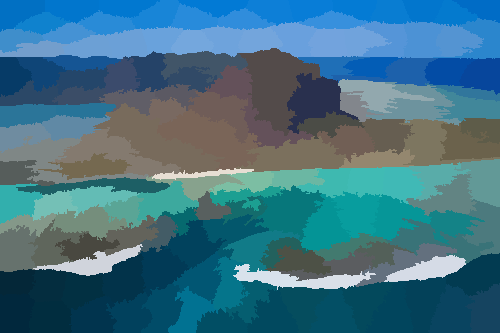

In [10]:
def find_mean_img(img_orig,seg_slic,arr_mean_seg):
    image1_mean = copy.copy(img_orig)
    for (index1, item1) in enumerate(seg_slic):
        for (index2, item2) in enumerate(item1):
            image1_mean[index1,index2] = arr_mean_seg[seg_slic[index1][index2]]
    return image1_mean

mean_1 = find_mean_img(image1_rgb,segments1,arr_mean_seg_1)
mean_1 = Image.fromarray(mean_1, 'RGB')
mean_1

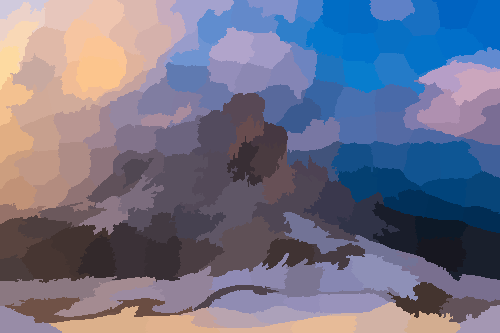

In [11]:
mean_2 = find_mean_img(image2_rgb,segments2,arr_mean_seg_2)
mean_2 = Image.fromarray(mean_2, 'RGB')
mean_2

In [12]:
def ssd(A,B):
    dif = A.ravel() - B.ravel()
    return np.dot( dif, dif )

arr_mean_seg_trans = []
arr_new_seg = []

for index1,item1 in enumerate(arr_mean_seg_1):
    arr = []
    for index2,item2 in enumerate(arr_mean_seg_2):
        arr.append(ssd(item1,item2))
    
    index_of_min = np.argmin(arr)
    
    arr_mean_seg_trans.append(arr_mean_seg_2[np.argmin(arr)])
    arr_new_seg.append(index_of_min)
    
arr_mean_seg_trans = np.array(arr_mean_seg_trans)
arr_new_seg = np.array(arr_new_seg)
len(arr_new_seg)
arr_new_seg

array([  9,  19,  19,  44,  19,  44,  44,  44,  44,  19,  19,   9,  17,
        17,  17,  17,  44,  17,  16,   8,   8,  30,  16,  30,  30,  30,
        30,   8,  30,  30,  30,  30,  30, 148, 102,  85,  87,  39, 101,
       102,  85,  13,  86,  84,  84, 153,  85, 102, 113, 157,  85,  52,
        55, 104,  85,  94,  60, 117,  80, 117,  55, 117,  55, 117, 148,
        47, 117, 124, 118,  52, 154, 117, 109, 145, 117, 109, 117,  51,
        97,  16,  16,  16,  15, 140,   8, 140, 143, 122,  90,  60,  17,
        84,  30,  39,  30, 104,  39,  39,  39,  90,  47,  58, 145, 102,
        84, 143, 102, 117,  85,  85, 117, 112,  77,  84, 134,  85,  85,
        97,  77,   0, 112, 148, 102, 104, 112, 120,   0,  84,   0, 125,
       120,   0, 120, 112, 102, 100, 100, 100, 100, 100,  84, 100, 100,
       100, 112, 120, 120, 120, 100])

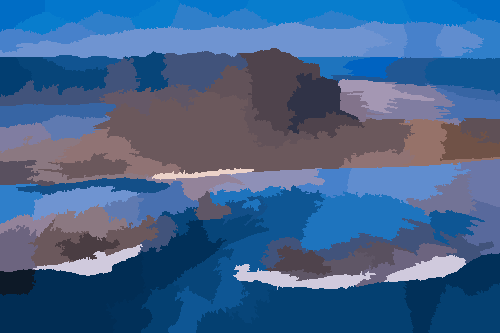

In [13]:
image1_mean = copy.copy(image1_rgb)
for (index1, item1) in enumerate(segments1):
    for (index2, item2) in enumerate(item1):
        image1_mean[index1,index2] = arr_mean_seg_trans[segments1[index1][index2]]
        
img = Image.fromarray(image1_mean, 'RGB')
img

doing A 0
Ai_flat (1, 988, 3)
doing B 9
Bi_flat (1, 805, 3)
Ai_new (1, 988, 3)
doing A 1
Ai_flat (1, 945, 3)
doing B 19
Bi_flat (1, 914, 3)
Ai_new (1, 945, 3)
doing A 2
Ai_flat (1, 776, 3)
doing B 19
Bi_flat (1, 914, 3)
Ai_new (1, 776, 3)
doing A 3
Ai_flat (1, 957, 3)
doing B 44
Bi_flat (1, 952, 3)
Ai_new (1, 957, 3)
doing A 4
Ai_flat (1, 747, 3)
doing B 19
Bi_flat (1, 914, 3)
Ai_new (1, 747, 3)
doing A 5
Ai_flat (1, 861, 3)
doing B 44
Bi_flat (1, 952, 3)
Ai_new (1, 861, 3)
doing A 6
Ai_flat (1, 731, 3)
doing B 44
Bi_flat (1, 952, 3)
Ai_new (1, 731, 3)
doing A 7
Ai_flat (1, 695, 3)
doing B 44
Bi_flat (1, 952, 3)
Ai_new (1, 695, 3)
doing A 8
Ai_flat (1, 766, 3)
doing B 44
Bi_flat (1, 952, 3)
Ai_new (1, 766, 3)
doing A 9
Ai_flat (1, 716, 3)
doing B 19
Bi_flat (1, 914, 3)
Ai_new (1, 716, 3)
doing A 10
Ai_flat (1, 711, 3)
doing B 19
Bi_flat (1, 914, 3)
Ai_new (1, 711, 3)
doing A 11
Ai_flat (1, 664, 3)
doing B 9
Bi_flat (1, 805, 3)
Ai_new (1, 664, 3)
doing A 12
Ai_flat (1, 828, 3)
doing B 1

doing A 100
Ai_flat (1, 731, 3)
doing B 47
Bi_flat (1, 970, 3)
Ai_new (1, 731, 3)
doing A 101
Ai_flat (1, 1278, 3)
doing B 58
Bi_flat (1, 1071, 3)
Ai_new (1, 1278, 3)
doing A 102
Ai_flat (1, 1403, 3)
doing B 145
Bi_flat (1, 2045, 3)
Ai_new (1, 1403, 3)
doing A 103
Ai_flat (1, 458, 3)
doing B 102
Bi_flat (1, 1144, 3)
Ai_new (1, 458, 3)
doing A 104
Ai_flat (1, 996, 3)
doing B 84
Bi_flat (1, 1260, 3)
Ai_new (1, 996, 3)
doing A 105
Ai_flat (1, 650, 3)
doing B 143
Bi_flat (1, 1766, 3)
Ai_new (1, 650, 3)
doing A 106
Ai_flat (1, 1329, 3)
doing B 102
Bi_flat (1, 1144, 3)
Ai_new (1, 1329, 3)
doing A 107
Ai_flat (1, 985, 3)
doing B 117
Bi_flat (1, 761, 3)
Ai_new (1, 985, 3)
doing A 108
Ai_flat (1, 696, 3)
doing B 85
Bi_flat (1, 911, 3)
Ai_new (1, 696, 3)
doing A 109
Ai_flat (1, 1639, 3)
doing B 85
Bi_flat (1, 911, 3)
Ai_new (1, 1639, 3)
doing A 110
Ai_flat (1, 1204, 3)
doing B 117
Bi_flat (1, 761, 3)
Ai_new (1, 1204, 3)
doing A 111
Ai_flat (1, 1431, 3)
doing B 112
Bi_flat (1, 859, 3)
Ai_new (1, 

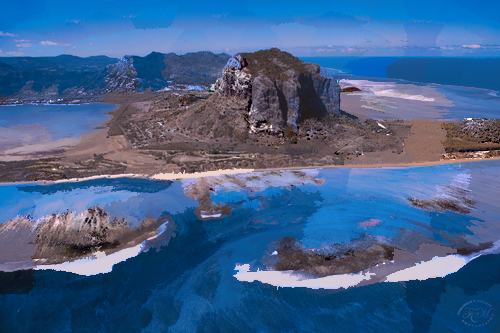

In [14]:
image1_after_trans = copy.copy(image1_rgb)

for index_of_seg_in_a in range(np.max(segments1)+1):
    print("doing A",index_of_seg_in_a)
    Ai_flat = []
    A_shape = image1_rgb.shape
    for i in range(A_shape[0]):
        for j in range(A_shape[1]):
            if segments1[i][j] == index_of_seg_in_a:
                Ai_flat.append(image1_rgb[i][j])
    Ai_flat = np.array([Ai_flat])
    print("Ai_flat",Ai_flat.shape)
    
    print("doing B", arr_new_seg[index_of_seg_in_a])
    Bi_flat = []
    B_shape = image2_rgb.shape
    for i in range(B_shape[0]):
        for j in range(B_shape[1]):
            if segments2[i][j] == arr_new_seg[index_of_seg_in_a]:
                Bi_flat.append(image2_rgb[i][j])
    Bi_flat = np.array([Bi_flat])
    print("Bi_flat",Bi_flat.shape)
    
    Ai_new = colour_transfer_MKL(Ai_flat,Bi_flat)
    print("Ai_new",Ai_new.shape)
    
    counting = 0
    for i in range(A_shape[0]):
        for j in range(A_shape[1]):
            if segments1[i][j] == index_of_seg_in_a:
                image1_after_trans[i][j] = Ai_new[0][counting]
                counting = counting + 1
                
                
img = Image.fromarray(image1_after_trans, 'RGB')
img

doing A 0
Ai_flat (1, 988, 3)
doing B 9
Bi_flat (1, 805, 3)
Ai_new (1, 988, 3)
doing A 1
Ai_flat (1, 945, 3)
doing B 19
Bi_flat (1, 914, 3)
Ai_new (1, 945, 3)
doing A 2
Ai_flat (1, 776, 3)
doing B 19
Bi_flat (1, 914, 3)
Ai_new (1, 776, 3)
doing A 3
Ai_flat (1, 957, 3)
doing B 44
Bi_flat (1, 952, 3)
Ai_new (1, 957, 3)
doing A 4
Ai_flat (1, 747, 3)
doing B 19
Bi_flat (1, 914, 3)
Ai_new (1, 747, 3)
doing A 5
Ai_flat (1, 861, 3)
doing B 44
Bi_flat (1, 952, 3)
Ai_new (1, 861, 3)
doing A 6
Ai_flat (1, 731, 3)
doing B 44
Bi_flat (1, 952, 3)
Ai_new (1, 731, 3)
doing A 7
Ai_flat (1, 695, 3)
doing B 44
Bi_flat (1, 952, 3)
Ai_new (1, 695, 3)
doing A 8
Ai_flat (1, 766, 3)
doing B 44
Bi_flat (1, 952, 3)
Ai_new (1, 766, 3)
doing A 9
Ai_flat (1, 716, 3)
doing B 19
Bi_flat (1, 914, 3)
Ai_new (1, 716, 3)
doing A 10
Ai_flat (1, 711, 3)
doing B 19
Bi_flat (1, 914, 3)
Ai_new (1, 711, 3)
doing A 11
Ai_flat (1, 664, 3)
doing B 9
Bi_flat (1, 805, 3)
Ai_new (1, 664, 3)
doing A 12
Ai_flat (1, 828, 3)
doing B 1

Ai_flat (1, 731, 3)
doing B 47
Bi_flat (1, 970, 3)
Ai_new (1, 731, 3)
doing A 101
Ai_flat (1, 1278, 3)
doing B 58
Bi_flat (1, 1071, 3)
Ai_new (1, 1278, 3)
doing A 102
Ai_flat (1, 1403, 3)
doing B 145
Bi_flat (1, 2045, 3)
Ai_new (1, 1403, 3)
doing A 103
Ai_flat (1, 458, 3)
doing B 102
Bi_flat (1, 1144, 3)
Ai_new (1, 458, 3)
doing A 104
Ai_flat (1, 996, 3)
doing B 84
Bi_flat (1, 1260, 3)
Ai_new (1, 996, 3)
doing A 105
Ai_flat (1, 650, 3)
doing B 143
Bi_flat (1, 1766, 3)
Ai_new (1, 650, 3)
doing A 106
Ai_flat (1, 1329, 3)
doing B 102
Bi_flat (1, 1144, 3)
Ai_new (1, 1329, 3)
doing A 107
Ai_flat (1, 985, 3)
doing B 117
Bi_flat (1, 761, 3)
Ai_new (1, 985, 3)
doing A 108
Ai_flat (1, 696, 3)
doing B 85
Bi_flat (1, 911, 3)
Ai_new (1, 696, 3)
doing A 109
Ai_flat (1, 1639, 3)
doing B 85
Bi_flat (1, 911, 3)
Ai_new (1, 1639, 3)
doing A 110
Ai_flat (1, 1204, 3)
doing B 117
Bi_flat (1, 761, 3)
Ai_new (1, 1204, 3)
doing A 111
Ai_flat (1, 1431, 3)
doing B 112
Bi_flat (1, 859, 3)
Ai_new (1, 1431, 3)
doi

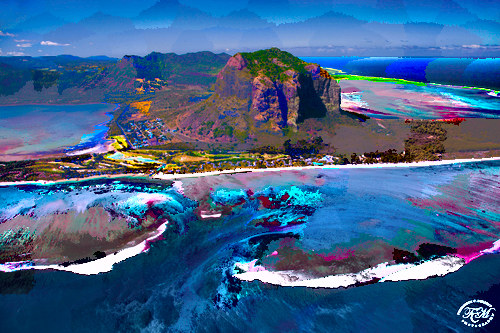

In [15]:
image1_after_trans = copy.copy(image1_rgb)

for index_of_seg_in_a in range(np.max(segments1)+1):
    print("doing A",index_of_seg_in_a)
    Ai_flat = []
    A_shape = image1_rgb.shape
    for i in range(A_shape[0]):
        for j in range(A_shape[1]):
            if segments1[i][j] == index_of_seg_in_a:
                Ai_flat.append(image1_rgb[i][j])
    Ai_flat = np.array([Ai_flat])
    print("Ai_flat",Ai_flat.shape)
    
    print("doing B", arr_new_seg[index_of_seg_in_a])
    Bi_flat = []
    B_shape = image2_rgb.shape
    for i in range(B_shape[0]):
        for j in range(B_shape[1]):
            if segments2[i][j] == arr_new_seg[index_of_seg_in_a]:
                Bi_flat.append(image2_rgb[i][j])
    Bi_flat = np.array([Bi_flat])
    print("Bi_flat",Bi_flat.shape)
    
    Ai_new = color_transfer(Bi_flat,Ai_flat)
    print("Ai_new",Ai_new.shape)
    
    counting = 0
    for i in range(A_shape[0]):
        for j in range(A_shape[1]):
            if segments1[i][j] == index_of_seg_in_a:
                image1_after_trans[i][j] = Ai_new[0][counting]
                counting = counting + 1
                
                
img = Image.fromarray(image1_after_trans, 'RGB')
img